In [1]:
import os, sys, time, copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()
VC_protocol = vc_protocols.leemV1_CiPA()

vhold = VC_protocol.steps[0].voltage

cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1320 ms


In [3]:
start_time = time.time()

model, p, s = myokit.load("../../../mmt-model-files/newordherg_qNet_fixedconc-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=-80)  # 1e-12, 1e-14  # 1e-08, 1e-10

# Control setting
params = {         
    'cell.mode': cell_types["Endocardial"],
    'setting.simType': 1,   # 0: AP   |  1: VC  
       
    'ikr.Temp' : 37,
    'ikr.Kt' : 3.5e-05,
    'ikr.Kmax' : 0,
    'ikr.Ku' : 0,
    'ikr.n' : 1,
    'ikr.halfmax' : 1,    
    'ikr.Vhalf' : 1, 
}
sim.set_simulation_params(params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.624176263809204 seconds ---


In [4]:
gen_params = {
    'end_time': VC_protocol.get_voltage_change_endpoints()[-1],     
    't_eval' : np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 0.1), # dt=0.2 ms
    'log_li' : ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa'],
    'save_log_li' : ['ina.INa', 'ikr.IKr', 'iks.IKs', 'ito.Ito', 'ical.ICaL',  'ik1.IK1', 'inal.INaL'],
    'nData' : 5,                         
    'dataset_dir' : "../../../../Dataset/newordherg_qNet_fixedconc_v1_LeemV1_Endocardial_dt01_5hERG_Gr",    
} 

# gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
print( gen_params['dataset_dir'] )


ds_params = {
    'window' : 20,
    'step_size' : 10,   
    'window_type' : 'avg',
    'noise_sigma' : 0
}  

sys.path.append(gen_params['dataset_dir'])
from agetdata import get_dataset, get_dataset2, get_currents_with_constant_dt

../../../../Dataset/newordherg_qNet_fixedconc_v1_LeemV1_Endocardial_dt01_5hERG_Gr


In [5]:
xs, ys = get_dataset2( file_numbers=range(1, 3), window=0, step_size=0, window_type=ds_params['window_type'],  multi=True, torch_tensor=False)
print(xs.shape, ys.shape)

100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 12318.07it/s]


--- 3.856311082839966 seconds ---
(10000, 13200) (10000, 12)


In [6]:
for i in range(12):
    print(ys[10:, i].min(), ys[10:, i].max())

12014.544255324985 74983335.30842148
4.868228984944434e-05 0.9999852431550443
0.500110587331501 1.999795770886258
56582.87735489853 999951311.3407432
-199.997145034412 -1.0059301636428017
1e-07 1.0
1e-07 1.0
1e-07 1.0
1e-07 1.0
1e-07 1.0
1e-07 1.0
1e-07 1.0


### Check time-step

In [7]:
dt=0.1
t_end = dt*xs.shape[-1]
times = np.arange(0, t_end, dt)
times[-1]

1319.9

### Check current

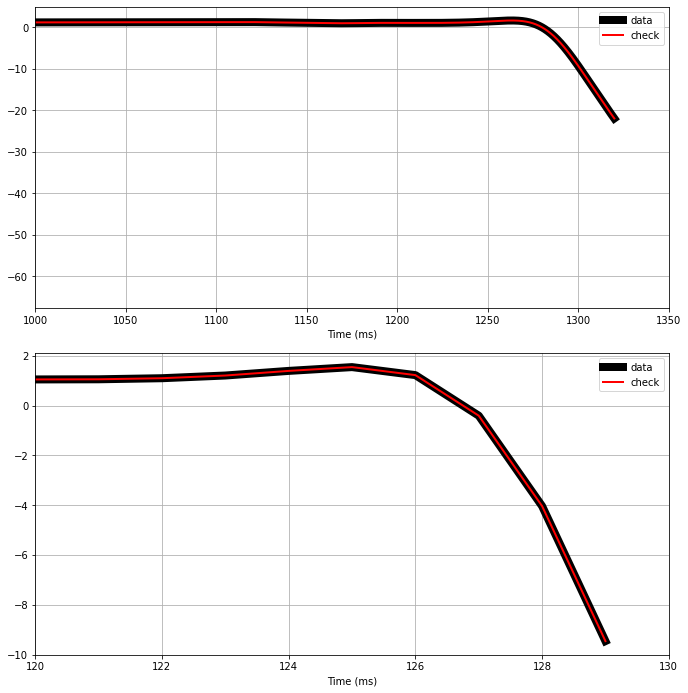

In [18]:
dataNo = 2000
    
sol1 = {}
# sol1["Time"] = xs[dataNo][0]# xs[dataNo, 0, :]  xs[dataNo][0]
# sol1["I_ion"] = xs[dataNo][1] + np.random.normal(0, 1, xs[dataNo][1].shape) 
sol1["Time"] = gen_params['t_eval']
sol1["I_ion"] = xs[dataNo, :] #+ np.random.normal(0, 1, xs[dataNo, :].shape)  
sol1["window"] = get_currents_with_constant_dt(params=ds_params, x=[sol1["Time"], sol1["I_ion"]])
y = ys[dataNo]

# sol1 = pd.DataFrame(data=sol1)
# sol1.head()
# gfc_li = {           
#     'ina.GNafc' : 1/y[0],  
#     'inal.GNaLfc' : 1/y[1],
#     'ito.Gtofc' : 1/y[2],
#     'ical.PCafc' : 1/y[3],
#     'ikr.GKrfc' : 1/y[4],
#     'iks.GKsfc' : 1/y[5],
#     'ik1.GK1fc' : 1/y[6],    
# }

gfc_li = {         
    # 'ikr.Kmax' : y[0],
    # 'ikr.Ku' : y[1],
    # 'ikr.n' : y[2],
    # 'ikr.halfmax' : y[3],
    # 'ikr.Vhalf' : y[4],
    
    'ikr.Kmax' : random.uniform(0, 10000000), # hERG_pars.loc['Kmax'].item(),
    'ikr.Ku' : random.uniform(0, 1), #hERG_pars.loc['Ku'].item(),
    'ikr.n' : random.uniform(0, 1), #hERG_pars.loc['n'].item(),
    'ikr.halfmax' : random.uniform(0, 147200000), #hERG_pars.loc['halfmax'].item(),    
    'ikr.Vhalf' : random.uniform(-90.65, 1), #hERG_pars.loc['Vhalf'].item(),     

    'ina.GNafc' : 1/y[5],  
    'inal.GNaLfc' : 1/y[6],
    'ito.Gtofc' : 1/y[7],
    'ical.PCafc' : 1/y[8],
    'ikr.GKrfc' : 1/y[9],
    'iks.GKsfc' : 1/y[10],
    'ik1.GK1fc' : 1/y[11],    
}
sim.set_simulation_params(gfc_li) 
# sim.model.get('ikr.Kmax').set_rhs( 0 )

sim.pre_simulate(5000, sim_type=1)
d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=['membrane.VC', 'membrane.i_ion']+gen_params['log_li'])                           

sol2 = {}
sol2["Time"] = d['engine.time']
# sol2["Voltage"] = d['membrane.VC']
sol2["I_ion"] = d['membrane.i_ion'] #+ np.random.normal(0, 1, d['membrane.i_ion'].shape) # add noise
sol2["window"] = get_currents_with_constant_dt(params=ds_params, x=[sol2["Time"], sol2["I_ion"]])
# sol2["I_Na"] = sim.current_response_info.get_current(['INa'])
# sol2["I_NaL"] = sim.current_response_info.get_current(['INaL'])
# sol2["I_To"] = sim.current_response_info.get_current(['Ito'])
# sol2["I_CaL"] = sim.current_response_info.get_current(['ICaL'])
# sol2["I_Kr"] = sim.current_response_info.get_current(['IKr'])
# sol2["I_Ks"] = sim.current_response_info.get_current(['IKs'])
# sol2["I_K1"] = sim.current_response_info.get_current(['IK1'])
# sol2 = pd.DataFrame(data=sol2)
# sol2.head()
# np.random.normal(0, noise_sigma, current.shape) # add noise

'''
Plot
'''
fig, ax = plt.subplots(2,1, figsize=(10,10))    

ax[0].set_xlabel('Time (ms)')       
# ax[0].set_ylabel(f'{name}')      
ax[0].plot( sol1['Time'], sol1['I_ion'], label='data', color='k', linewidth=8)     
ax[0].plot( sol2['Time'], sol2['I_ion'], label='check', color='r', linewidth=2)    
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel('Time (ms)')       
# ax[1].set_ylabel(f'{name}')      
ax[1].plot( sol1['window'], label='data', color='k', linewidth=8)     
ax[1].plot( sol2['window'], label='check', color='r', linewidth=2)    
ax[1].legend()
ax[1].grid()

ax[0].set_xlim(1000, 1350)
ax[1].set_xlim(120, 130)
# ax[0].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)    
# fig.savefig(os.path.join('Test_results', f"{dataNo}.jpg"), dpi=100)
plt.show()    

In [9]:
for dataNo in range(1):
    
    sol1 = {}
    sol1["Time"] = xs[dataNo][0]
    sol1["I_ion"] = xs[dataNo][1]
    sol1["window"] = get_currents_with_constant_dt(params=ds_params, x=[sol1["Time"], sol1["I_ion"]])
    y = ys[dataNo]

    # sol1 = pd.DataFrame(data=sol1)
    # sol1.head()
    
    gfc_li = {         
        'ina.GNafc' : y[0],  
        'inal.GNaLfc' : y[1],
        'ito.Gtofc' : y[2],
        'ical.PCafc' : y[3],
        'ikr.GKrfc' : y[4],
        'iks.GKsfc' : y[5],
        'ik1.GK1fc' : y[6],    
    }
    sim.set_simulation_params(gfc_li) 


    sim.pre_simulate(5000, sim_type=1)
    d = sim.simulate( gen_params['end_time'], extra_log=['membrane.VC', 'membrane.i_ion']+gen_params['log_li'])                           

    sol2 = {}
    sol2["Time"] = d['engine.time']
    # sol2["Voltage"] = d['membrane.VC']
    sol2["I_ion"] = d['membrane.i_ion'] #+ np.random.normal(0, 2, d['membrane.i_ion'].shape) # add noise
    sol2["window"] = get_currents_with_constant_dt(params=ds_params, x=[sol2["Time"], sol2["I_ion"]])
    # sol2["I_Na"] = sim.current_response_info.get_current(['INa'])
    # sol2["I_NaL"] = sim.current_response_info.get_current(['INaL'])
    # sol2["I_To"] = sim.current_response_info.get_current(['Ito'])
    # sol2["I_CaL"] = sim.current_response_info.get_current(['ICaL'])
    # sol2["I_Kr"] = sim.current_response_info.get_current(['IKr'])
    # sol2["I_Ks"] = sim.current_response_info.get_current(['IKs'])
    # sol2["I_K1"] = sim.current_response_info.get_current(['IK1'])
    # sol2 = pd.DataFrame(data=sol2)
    # sol2.head()
    # np.random.normal(0, noise_sigma, current.shape) # add noise
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(2,1, figsize=(20,10))    
    
    ax[0].set_xlabel('Time (ms)')       
    # ax[0].set_ylabel(f'{name}')      
    ax[0].plot( sol1['Time'], sol1['I_ion'], label='data', color='k', linewidth=3)     
    # ax[0].plot( sol2['Time'], sol2['I_ion'], label='check', color='r', linewidth=2)    
    ax[0].legend()
    ax[0].grid()
    
    ax[1].set_xlabel('Time (ms)')       
    # ax[1].set_ylabel(f'{name}')      
    ax[1].plot( sol1['window'], label='data', color='k', linewidth=3)     
    # ax[1].plot( sol2['window'], label='check', color='r', linewidth=2)    
    ax[1].legend()
    ax[1].grid()
    

    # ax[-1].set_ylim(-5, 5)

    plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)    
#     fig.savefig(os.path.join('Test_results', f"{dataNo}.jpg"), dpi=100)
    
# plt.show()    
print("finish")

IndexError: invalid index to scalar variable.